In [91]:
# Preprocessing
import numpy as np
import pandas as pd
from ai_cdss.constants import *
from ai_cdss.processing import expand_session_batch
from utils import filter_study_range

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec

# Modelling
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import scipy.stats as stats


In [92]:
clinical_scores = pd.read_csv("data/nest_T01.csv")
clinical_scores['DIFF'] = clinical_scores['T1'] - clinical_scores['T0']
data = pd.read_parquet("data/nest_data.parquet")

In [96]:
# study_data = data.groupby('PATIENT_ID', group_keys=False).apply(filter_study_range)
study_data = data.copy()
# Compute patient-level "Day Index"
study_data['DAY_INDEX'] = study_data.groupby('PATIENT_ID')['SESSION_DATE'].transform(
    lambda x: (x - x.min()).dt.days
)

In [98]:
nest_dms = study_data[BY_ID + ["SECONDS_FROM_START", "DM_VALUE", "PE_VALUE", "PPF", "CONTRIB", "DAY_INDEX"]]
nest_dms.sort_values(
    by=["PATIENT_ID", "DAY_INDEX", "SESSION_ID", "SECONDS_FROM_START"],
    inplace=True,
)

/tmp/ipykernel_2262652/1734973332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nest_dms.sort_values(


In [ ]:
def get_confidence_intervals(popt, pcov, confidence=0.95):
    alpha = 1.0 - confidence
    dof = max(0, len(popt) - 1)
    tval = stats.t.ppf(1.0 - alpha / 2., dof)
    perr = np.sqrt(np.diag(pcov))
    intervals = [(param - tval * err, param + tval * err) for param, err in zip(popt, perr)]
    return intervals

def compute_metrics(
        df,
        alpha=0.5,
        window_size=7,
        scaling_factor=2,
        min_window=5,
        max_window=21,
        polyorder=2,
        deriv=1,
    ):
    df = df.reset_index(drop=True)

    # Parameter for Savitzky-Golay
    window_length = window_size or int(np.clip(1 / alpha * scaling_factor, min_window, max_window))
    if window_length % 2 == 0:
        window_length += 1

    # Time index
    t = np.arange(len(df))
    t_safe = t + 1  # to avoid log(0)

    # Delta DM
    df['DELTA_DM'] = df['DM_VALUE'].diff().fillna(0)
    # EWMA
    df['DELTA_DM_EWMA'] = df['DELTA_DM'].ewm(alpha=alpha, adjust=True).mean()

    # Savitzky-Golay filter
    try:
        df['SG_DM'] = savgol_filter(df['DM_VALUE'], window_length=window_length, polyorder=polyorder, deriv=deriv)
    except ValueError:
        df['SG_DM'] = df['DM_VALUE']

    # === Logarithmic Fit ===
    def log_func(x, a, b):
        return a * np.log(x + 1) + b

    try:
        popt_log, pcov_log = curve_fit(log_func, t_safe, df['DM_VALUE'], maxfev=10000)
        df['LOG_FIT_DM'] = log_func(t_safe, *popt_log)
        r2_log = r2_score(df['DM_VALUE'], df['LOG_FIT_DM'])
        ci_log = get_confidence_intervals(popt_log, pcov_log)
    except Exception as e:
        df['LOG_FIT_DM'] = np.nan
        popt_log = (np.nan, np.nan)
        r2_log = np.nan
        ci_log = [(np.nan, np.nan)] * 2
        print(f"[Log Fit] Failed: {e}")

    # === Exponential Fit ===
    def exp_func(x, a, b, c):
        return a * np.exp(-b * x) + c

    try:
        popt_exp, pcov_exp = curve_fit(exp_func, t, df['DM_VALUE'], maxfev=10000)
        df['EXP_FIT_DM'] = exp_func(t, *popt_exp)
        r2_exp = r2_score(df['DM_VALUE'], df['EXP_FIT_DM'])
        ci_exp = get_confidence_intervals(popt_exp, pcov_exp)
    except Exception as e:
        df['EXP_FIT_DM'] = np.nan
        popt_exp = (np.nan, np.nan, np.nan)
        r2_exp = np.nan
        ci_exp = [(np.nan, np.nan)] * 3
        print(f"[Exp Fit] Failed: {e}")

    # === Logistic Fit ===
    def logistic_func(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))

    try:
        popt_logistic, pcov_logistic = curve_fit(
            logistic_func, t, df['DM_VALUE'],
            p0=[1.0, 1.0, np.median(t)],
            maxfev=10000
        )
        df['LOGISTIC_FIT_DM'] = logistic_func(t, *popt_logistic)
        r2_logistic = r2_score(df['DM_VALUE'], df['LOGISTIC_FIT_DM'])
        ci_logistic = get_confidence_intervals(popt_logistic, pcov_logistic)
    except Exception as e:
        df['LOGISTIC_FIT_DM'] = np.nan
        popt_logistic = (np.nan, np.nan, np.nan)
        r2_logistic = np.nan
        ci_logistic = [(np.nan, np.nan)] * 3
        print(f"[Logistic Fit] Failed: {e}")

    # Store everything in attrs
    df.attrs.update({
        # Logarithmic
        'log_fit_params': popt_log,
        'log_fit_r2': r2_log,
        'log_fit_ci': ci_log,

        # Exponential
        'exp_fit_params': popt_exp,
        'exp_fit_r2': r2_exp,
        'exp_fit_ci': ci_exp,

        # Logistic
        'logistic_fit_params': popt_logistic,
        'logistic_fit_r2': r2_logistic,
        'logistic_fit_ci': ci_logistic,
    })

    return df

In [111]:
def plot_fit(df, filename=None):
    # Plotting
    fig = plt.figure(figsize=(12, 8))
    spec = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1])  # 3/4 for DM, 1/4 for PE

    # --- DM
    ax_dm = fig.add_subplot(spec[0])
    sns.lineplot(data=df, x=df.index, y='DM_VALUE', color='blue', alpha=0.5)
    sns.lineplot(data=df, x=df.index, y='LOGISTIC_FIT_DM', color='orange', alpha=0.9)
    df["SG_DM_CUM"] = df['SG_DM'].cumsum()
    sns.lineplot(data=df, x=df.index, y='SG_DM_CUM', color='purple', alpha=0.9)

    ax_dm.set_xlabel('')
    ax_dm.set_ylabel('DM Value')
    ax_dm.tick_params(labelbottom=False)
    ax_dm.spines['right'].set_visible(False)

    # --- PE
    ax_pe = fig.add_subplot(spec[1], sharex=ax_dm)
    sns.lineplot(data=df, x=df.index, y='PE_VALUE', color='green', alpha=0.5)
    plt.axhline(y=0.7, color='r', linestyle='--')
    ax_pe.set_ylabel('PE Value')

    if filename:
        plt.savefig(filename, bbox_inches='tight')
    else:
        plt.show()
    plt.close()

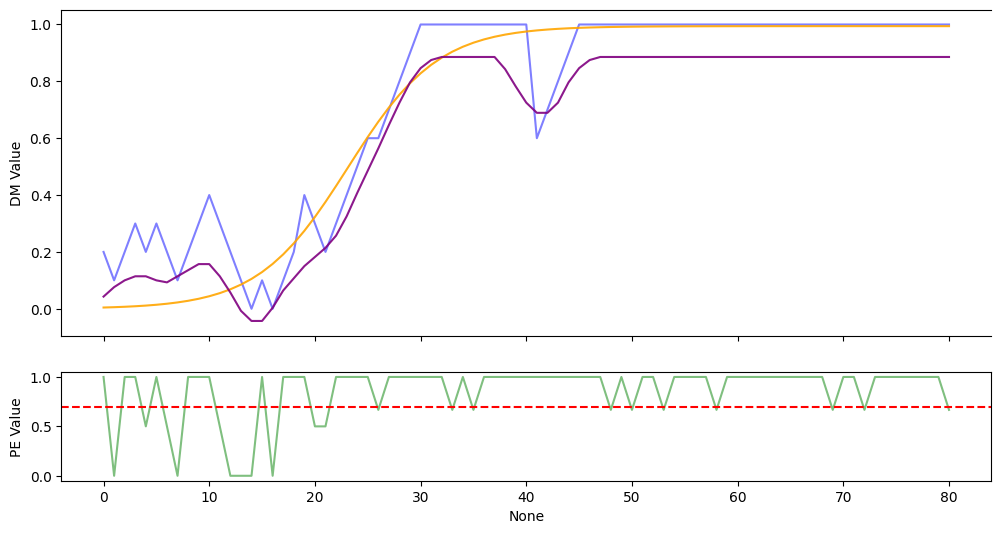

Patient: 775, Session: 206
Log Fit Params: [ 0.36307033 -0.53528438], R²: 0.7182347474387092
Exp Fit Params: [-1.24700629  0.02977597  1.20858739], R²: 0.7931369237300843
Logistic Fit Params: [ 0.99412219  0.23396478 23.12799543], R²: 0.8911696404785441
SNR (Logistic Model): 11.577857088036248


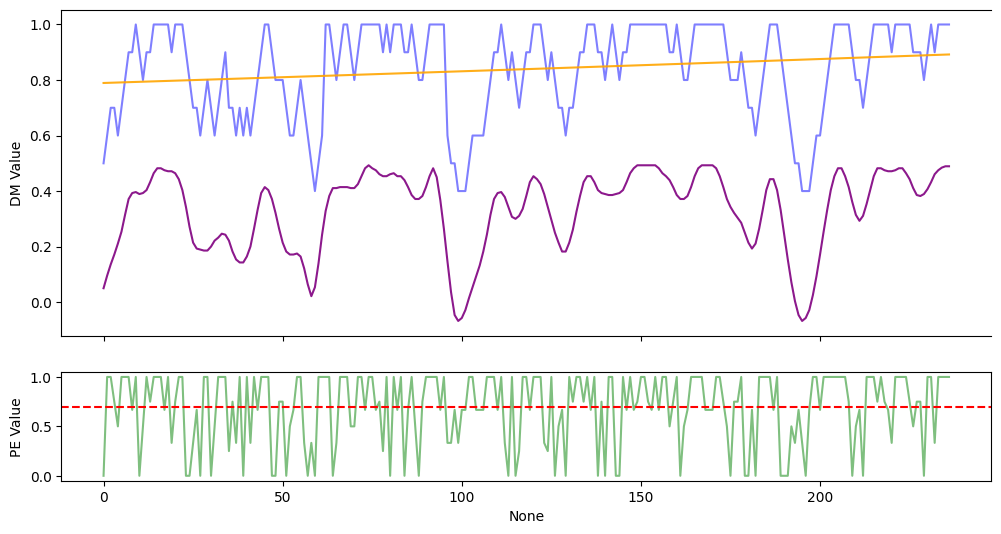

Patient: 775, Session: 208
Log Fit Params: [0.03184528 0.69614964], R²: 0.030762218964312082
Exp Fit Params: [-0.36174536  0.36208335  0.84468705], R²: 0.03799180665766322
Logistic Fit Params: [3.48477501e+01 5.30985773e-04 7.08991419e+03], R²: 0.03209289539142468
SNR (Logistic Model): 0.03323248386013543


/tmp/ipykernel_2262652/3439473746.py:60: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


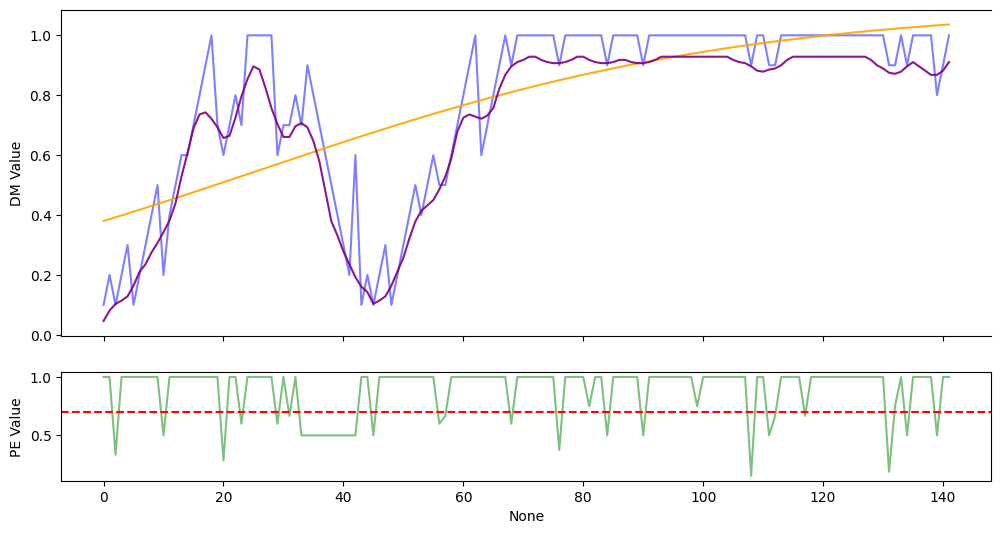

Patient: 775, Session: 214
Log Fit Params: [ 0.22835163 -0.13718633], R²: 0.4852132912314535
Exp Fit Params: [-0.86857552  0.01176296  1.20420924], R²: 0.4803984935361686
Logistic Fit Params: [1.09690097e+00 2.46178894e-02 2.57781187e+01], R²: 0.48135368266838763
SNR (Logistic Model): 0.9330669663348556


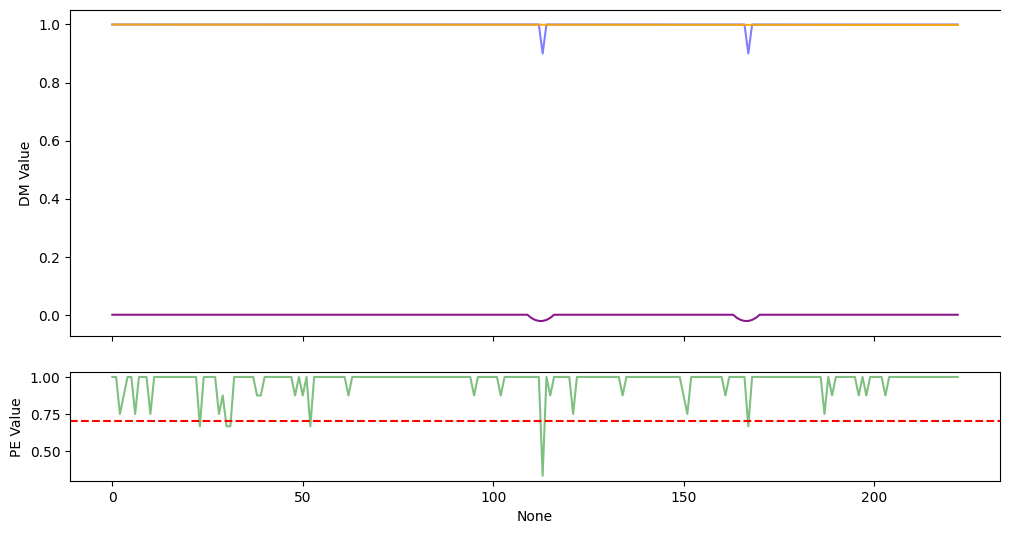

Patient: 775, Session: 222
Log Fit Params: [-5.29715773e-04  1.00145915e+00], R²: 0.0026176563128558206
Exp Fit Params: [0.002125   0.01683769 0.99854562], R²: 0.0033800649986758247
Logistic Fit Params: [ 2.00223301e+00 -1.25386292e-05 -2.09787883e+02], R²: 0.0018366017486163289
SNR (Logistic Model): 0.001839972499025867


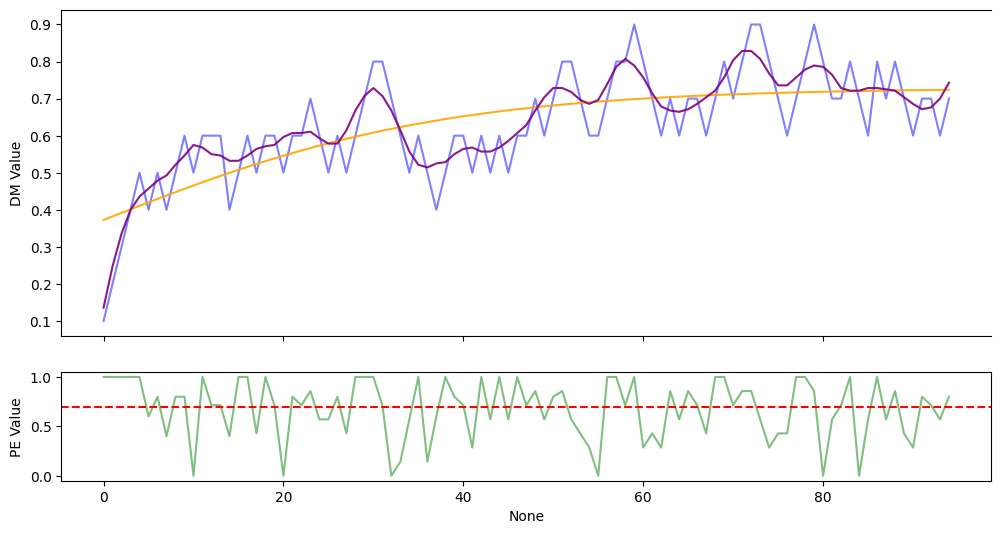

Patient: 775, Session: 224
Log Fit Params: [0.12766414 0.16534141], R²: 0.5695535227434567
Exp Fit Params: [-0.40600785  0.04451422  0.72620531], R²: 0.5343046536756768
Logistic Fit Params: [ 0.72886358  0.05240175 -0.86961565], R²: 0.5174198566805691
SNR (Logistic Model): 1.0335135005493992


In [112]:
for i, g in nest_dms.groupby(BY_PP):
    if i[0] != 775:
        continue

    df = compute_metrics(g)
    plot_fit(df)

    print(f"Patient: {i[0]}, Session: {i[1]}")
    print(f"Log Fit Params: {df.attrs['log_fit_params']}, R²: {df.attrs['log_fit_r2']}")
    print(f"Exp Fit Params: {df.attrs['exp_fit_params']}, R²: {df.attrs['exp_fit_r2']}")
    print(f"Logistic Fit Params: {df.attrs['logistic_fit_params']}, R²: {df.attrs['logistic_fit_r2']}")


    signal = df['LOGISTIC_FIT_DM']
    noise = df['DM_VALUE'] - df['LOGISTIC_FIT_DM']

    snr_model = np.var(signal) / np.var(noise)
    print(f"SNR (Logistic Model): {snr_model}")
    # r2 = df.attrs['logistic_fit_r2']
    # print(f"SNR (from R2): {r2 / (1 - r2)}]")

    # break
    # plt.show()

    # plt.figure(figsize=(8, 2))
    # sns.lineplot(df, x=df.index, y="PE_VALUE")
    # plt.axhline(y=0.7, color='r', linestyle='--')
    

In [2]:
import os
# Prepare output dirs
output_dir = 'dm_fit_plots'
os.makedirs(output_dir, exist_ok=True)

# Results table
results = []

# Iterate over patient-protocols
for (patient_id, protocol_id), group in nest_dms.groupby(BY_PP):
    df = compute_metrics(group)

    plot_filename = f"dm_model_{patient_id}_{protocol_id}.png"
    # Save the plot
    plot_fit(df, filename=os.path.join(output_dir, plot_filename))

    # Extract attributes
    logistic_params = df.attrs['logistic_fit_params']
    logistic_ci = df.attrs['logistic_fit_ci']
    logistic_r2 = df.attrs['logistic_fit_r2']

    # CI widths
    ci_widths = [high - low for (low, high) in logistic_ci]

    # Append to results
    results.append({
        'PATIENT_ID': patient_id,
        'PROTOCOL_ID': protocol_id,
        'logistic_R2': logistic_r2,
        'L': logistic_params[0],
        'k': logistic_params[1],
        'x0': logistic_params[2],
        'CI_L_width': ci_widths[0],
        'CI_k_width': ci_widths[1],
        'CI_x0_width': ci_widths[2],
        'plot_filename': plot_filename
    })


NameError: name 'nest_dms' is not defined

In [ ]:
results_df = pd.DataFrame(results)
# Optional: Save to CSV
results_df.to_csv("logistic_fit_summary.csv", index=False)

In [ ]:
hist_dir = 'dm_fit_histograms'
os.makedirs(hist_dir, exist_ok=True)

# Plot histogram of R²
plt.figure(figsize=(6, 4))
sns.histplot(results_df['logistic_R2'], bins=20, kde=True)
plt.title('Distribution of Logistic Fit R²')
plt.xlabel('R²')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(hist_dir, "logistic_r2_distribution.png"))
plt.close()

# Plot histogram of CI widths
plt.figure(figsize=(6, 4))
sns.histplot(results_df['CI_k_width'], bins=20, kde=True)
plt.title('Distribution of CI Width for k (Growth Rate)')
plt.xlabel('CI Width')
plt.ylabel('Frequency')
plt.tight_layout()
# plt.savefig(os.path.join(hist_dir, "ci_k_width_distribution.png"))
# plt.close()

# Build HTML report
html_hist = """
<html>
<head>
<style>
body { font-family: Arial, sans-serif; }
img { width: 600px; height: auto; margin-bottom: 20px; }
</style>
</head>
<body>
<h2>Global Model Quality Histograms</h2>
<img src="dm_fit_histograms/logistic_r2_distribution.png">
<img src="dm_fit_histograms/ci_k_width_distribution.png">
</body>
</html>
"""

with open("dm_fit_histograms_report.html", "w") as f:
    f.write(html_hist)


In [85]:
html_report = """
<html>
<head>
<style>
body { font-family: Arial, sans-serif; }
table { border-collapse: collapse; width: 100%; }
th, td { border: 1px solid #ddd; padding: 8px; text-align: center; }
img { width: 300px; height: auto; }
</style>
</head>
<body>
<h2>DM vs Fitted Models Report</h2>
<table>
<tr>
<th>Patient</th>
<th>Protocol</th>
<th>Plot</th>
</tr>
"""

for _, row in results_df.iterrows():
    html_report += f"""
    <tr>
        <td>{row['PATIENT_ID']}</td>
        <td>{row['PROTOCOL_ID']}</td>
        <td><img src="{os.path.join(output_dir, row['plot_filename'])}"></td>
    </tr>
    """

html_report += """
</table>
</body>
</html>
"""

with open("dm_fit_report.html", "w") as f:
    f.write(html_report)